# 1. Import and config

In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")

In [2]:
from dnndk import n2cube
import numpy as np
from numpy import float32
import os
import cv2
import matplotlib.pyplot as plt
import time
import DpuFER
from DpuFER import CommonFunction,DpuFer

In [3]:
KERNEL_CONV="dpuModel_0"
# 训练用的图像尺寸
img_size_net = 128
# 训练的batch大小
batch_size = 32
wordlist = ['angry', 'contemptuous', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
sorts_pathes = ['angry', 'contemptuous', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
run_path = './'

# 存放转换后的tf数据集的路径
# dataset_tf_path_train = run_path + 'datasetTfTrain.tfrecords'
# dataset_tf_path_test = run_path + 'datasetTfTest.tfrecords'
CONV_INPUT_NODE = "x_input_Conv2D"
CONV_OUTPUT_NODE = "y_out_MatMul"

# 2. Loading the dataset

In [4]:
sorts_list = ['angry', 'contemptuous', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
img_size_net = 128
CONV_INPUT = "conv2d_input"
calib_batch_size = 30

def load_valid_data(data_path):
    label_cnt = 0
    test_images = []
    test_lables = []
    for sort_path in sorts_list:    
        flower_list = os.listdir(data_path + sort_path)
        for img_name in flower_list:
            img_path = data_path + sort_path + "/" + img_name
            img = cv2.imread(img_path)  
            img_scale = cv2.resize(img,(img_size_net, img_size_net), interpolation = cv2.INTER_CUBIC)
            if not img is None:
                test_images.append(img_scale / 255.)
                test_lables.append(label_cnt)
        label_cnt += 1             
    return test_images, test_lables

dataset_valid_path = './dataset_valid_FER/'
(validSet_images, validSet_lables) = load_valid_data(dataset_valid_path)
validSet_images = np.array(validSet_images)
validSet_lables = np.array(validSet_lables)
def calib_input(iter):
    images = []
    for index in range(0, calib_batch_size):
        images.append(validSet_images[index])

    return {CONV_INPUT: images}

# 3. DPU experiment

## 3.1 Load kernel to DPU

In [5]:
# DPU setpu
n2cube.dpuOpen()
kernel = n2cube.dpuLoadKernel(KERNEL_CONV)
DPU_TASK = n2cube.dpuCreateTask(kernel, mode=2)
agent1 = DpuFer(DPU_TASK)

160.0 120.0
30.0


## 3.2 Test experiment with valid_dataset


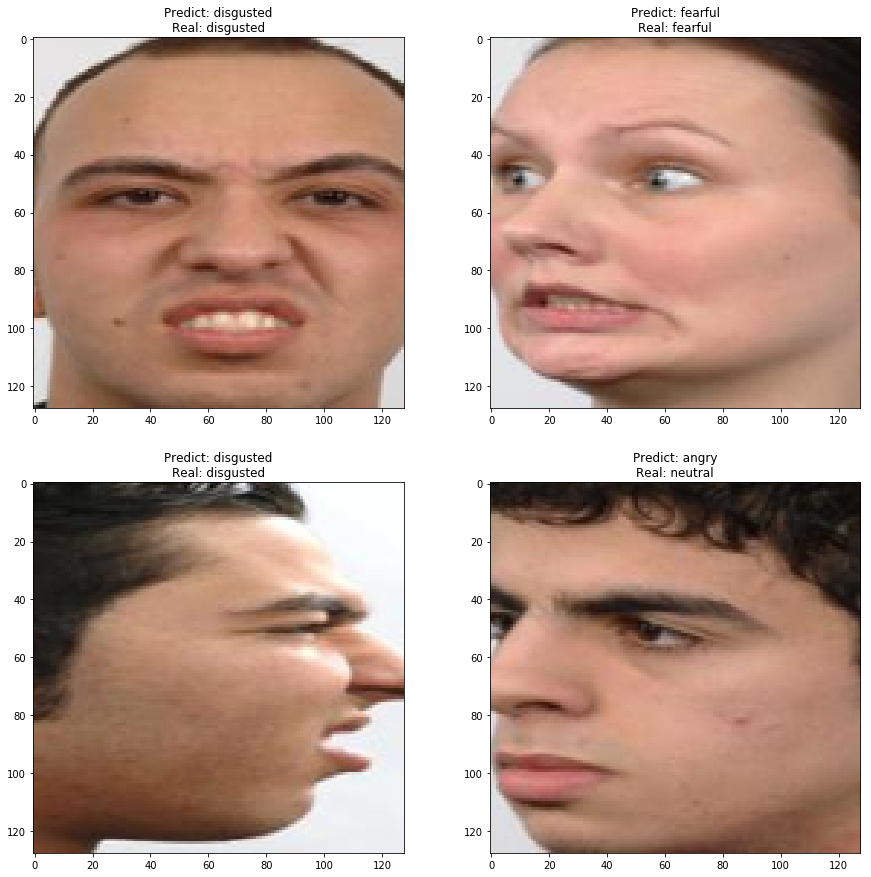

In [6]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(15,15)
for i in range(2):
    for j in range(2):
        l = np.random.randint(0, len(validSet_lables)-1)
        img1_scale = validSet_images[l]
        pdt = agent1.dpuPredictSoftmax(img1_scale)
        img1_scale = np.array(img1_scale, dtype='float32')
        ax[i, j].imshow(cv2.cvtColor(img1_scale, cv2.COLOR_BGR2RGB))
        title = "Predict: " + wordlist[pdt] + "\n" + "Real: " + wordlist[validSet_lables[l]]
        ax[i, j].set_title(title)
#plt.tight_layout()

# 3.3 Test experiment with USB camera

Please connect the USB camera to the Ultra 96 first.

In [7]:
for i in range(3000):
    # clear the output
    
    # read image from camera
    t_start = time.time()
    imgMat = agent1.get_image()
    # this image is used for display
    imgShow = cv2.resize(imgMat, (320,240))
    # this image is used for DPU input
    tempImg = cv2.resize(imgMat, (128,128))
    pdt = agent1.dpuPredictSoftmax(tempImg)
    t_end = time.time()
#    print('t', str(t_end - t_start))
    font=cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(imgShow,wordlist[pdt],(10,50), font, 1,(255,0,0),2)
    # show result
#     print(wordlist[pdt])
    CommonFunction.show_img_jupyter(imgShow)
    CommonFunction.clear_output()
#    time.sleep(0.1)

KeyboardInterrupt: 

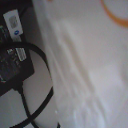

In [ ]:
haar_front_face_xml = './haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(haar_front_face_xml)

while True:

    # clear the output
    # 

    # read image from camera
    imgMat = agent1.get_image()
    # this image is used for display
    imgShow = cv2.resize(imgMat, (320,240))
    # this image is used for DPU input
    tempImg = cv2.resize(imgMat, (128,128))

    # Convert to gray image
    img_gray = cv2.cvtColor(tempImg, cv2.COLOR_BGR2GRAY)
    # Detect faces
    faces = face_cascade.detectMultiScale(img_gray, 1.3, 5)

    # Plot to image
    for (x, y, w, h) in faces:
        # Plot rectangle
        img = cv2.rectangle(tempImg, (x, y), (x + w, y + h), (255, 0, 0), 2)
        # crop image
        face = tempImg[x:x+w, y:y+h]
        # Predict emotion
        pdt = agent1.dpuPredictSoftmax(face)
        # Put names
        #fontScale = min(w, h / (950 / scale))
        cv2.putText(tempImg, wordlist[pdt], (x, y + 10),
                cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 0, 0), 2)
        # show result
    CommonFunction.show_img_jupyter(tempImg)
    CommonFunction.clear_output()
        # sleep
        #time.sleep(0.1)

In [14]:
haar_front_face_xml = './haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(haar_front_face_xml)
print(face_cascade)

<CascadeClassifier 0x7f75679e50>
